
# Bound constrained minimization with PETSc-VI solvers

This example solve the bound constrained minimization problem
 in the domain $(x,y)$ in $\Omega \equiv (0,L_x)\times(0,L_y)$

 $$\min_{u\in\mathcal C}\, \mathcal{F}(u),\qquad \text{with}\qquad u\in\mathcal{C}\equiv\{u\in H_1(\Omega):\;0\leq u\leq 1,\;u(0,y)= 0,\;u(L_x,y) = 1\}$$

 where $\mathcal{F}(u)$ is the functional defined by the form

 $$\mathcal{F}(u) =\int_\Omega \left(\frac{w(u)}{\ell}+\ell\, \nabla u\cdot  \nabla u\right)\mathrm{d}x$$
 
 The solution $u^*\in\mathcal{C} $ to this problem must verify the following Variational Inequality (VI):
 
$$ \mathcal{F}'(u^*)(v-u^*)\geq 0,\quad \forall v \in\mathcal{C} $$

We show below how to solve this problem with FEniCS using the VI solvers provided by PETSc

To define the problem we need to specify the 
 - The functional to be minimized $\mathcal{F}$, and its first and second directional derivatives
 - The lower $u_L$ and upper  $u_U$ bounds, here given by $0$ and $1$ respectively.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx
import dolfinx.plot
import dolfinx.io
import ufl

from mpi4py import MPI
from petsc4py import PETSc

import pyvista
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0.0)

## Mesh, function space, boundary condition

We first define the mesh, the function space, and the boundary conditions, as usual

We discretize the field with standard $P_1$ finite elements

In [2]:
L = 1.0
H = 0.2
mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, [(0.0, 0.0, 0.0), (L, H, 0.0)], [100, 15])

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "w") as f:
    f.write_mesh(mesh)

V = dolfinx.FunctionSpace(mesh, ("CG", 1))           
                               
zero = dolfinx.Function(V)
with zero.vector.localForm() as loc:
    loc.set(0.0)
    
one = dolfinx.Function(V)
with one.vector.localForm() as loc:
    loc.set(1.0)
    
def left(x):
    is_close = np.isclose(x[0], 0.0)
    return is_close

def right(x):
    is_close = np.isclose(x[0], L)
    return is_close

left_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, left_facets)

right_facets = dolfinx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left)
right_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, right_facets)

bcs = [dolfinx.DirichletBC(zero, left_dofs), dolfinx.DirichletBC(one, right_dofs)]

## The functional to by minimized

We define here the functional and its directional derivatives

In [3]:
u = dolfinx.Function(V)

ell = 0.3

def w(alpha):
    return alpha

functional = (ell * ufl.inner(ufl.grad(u), ufl.grad(u)) + w(u)/ell)*ufl.dx

dfunctional = ufl.derivative(functional, u, ufl.TestFunction(V))

ddfunctional = ufl.derivative(dfunctional, u, ufl.TrialFunction(V))

## Set up the SNES VI solver

To slve the problem we use the variational inequality solver `SNES` provided by `PETSc`. 

To use the `SNES` solver we need to provide suitable function to assemble the residual and the Jacobian, as for the Netwon solver, but with few differences. A class doing this job ggiven the the FEniCS form, the Function and the BCs is provided in the file [../python/snes_problem.py](../python/snes_problem.py).

**Exercice "Find the differences":** Which are the difference between `SNESProblem` and `NonlinearPDEProblem`? Why are they necessary in your opinion? Look how the class are used. 

In [4]:
import sys
sys.path.append("../python/")
from snes_problem import SNESProblem

snes_problem = SNESProblem(dfunctional, ddfunctional, u, bcs)

We set up now the `SNES` solver though the `petsc4py` python interface

Note that we assing the solvers:
- the function to evaluate the function (residual)
- the function to evaluate the Jacobian
- the bounds

We select the specific VI solver `vinewtonrsls`


In [5]:
b = dolfinx.cpp.la.create_vector(V.dofmap.index_map, V.dofmap.index_map_bs)
J = dolfinx.fem.create_matrix(snes_problem.a)

# Create Newton solver and solve
solver_snes = PETSc.SNES().create()
solver_snes.setType("vinewtonrsls")
solver_snes.setFunction(snes_problem.F, b)
solver_snes.setJacobian(snes_problem.J, J)
solver_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_snes.getKSP().setType("preonly")
solver_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_snes.getKSP().getPC().setType("lu")

# We set the bound (Note: they are passed as reference and not as values)
solver_snes.setVariableBounds(zero.vector,one.vector)

## Solve the problem

We can now solve the problem

In [6]:
solver_snes.solve(None, u.vector)

## Prostprocessing

We save to file and plot the solution

In [7]:
from pathlib import Path
Path("output").mkdir(parents=True, exist_ok=True)

with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/u.xdmf", "w") as f:
    f.write_mesh(mesh)
    f.write_function(u)

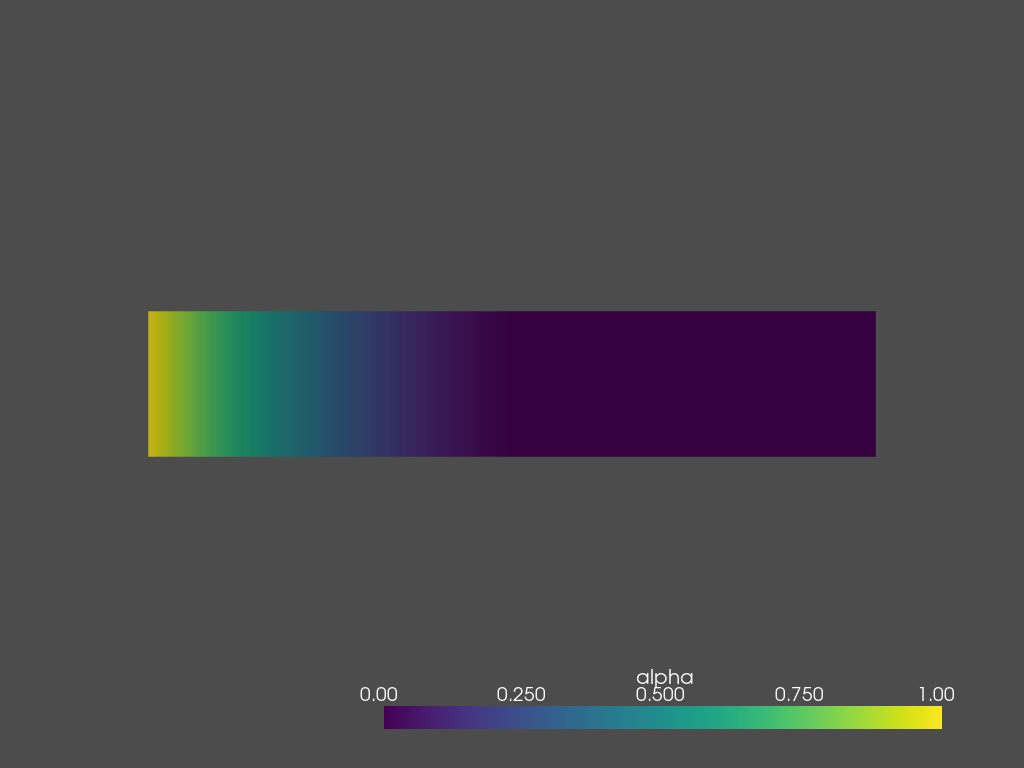

In [8]:
import dolfinx.plot
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
import pyvista
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

grid.point_arrays["alpha"] = u.compute_point_values().real
grid.set_active_scalars("alpha")

pyvista.start_xvfb(wait=0.05)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False, show_scalar_bar=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
figure = plotter.screenshot("output/u.png")

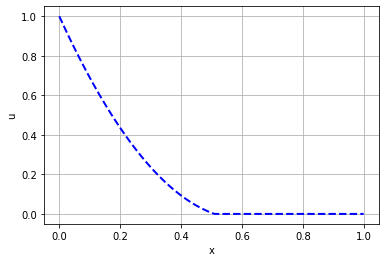

In [13]:
from utils import evaluate_on_points

points = np.zeros((3, 101))
points[0] = np.linspace(0., 1., 101)
points[1] = .1

points_on_proc, u_values = evaluate_on_points(u, points)

import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(points_on_proc[:, 0], u_values, "b--", linewidth = 2)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("u")
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"output/membrane_rank{MPI.COMM_WORLD.rank:d}.png")